In [46]:
from templates import *
import matplotlib.pyplot as plt
import numpy as np

In [47]:
device = 'cuda:1'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [48]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    data[0]['img'],
    data[1]['img'],
])

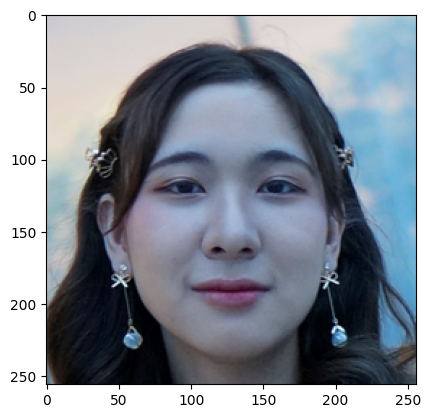

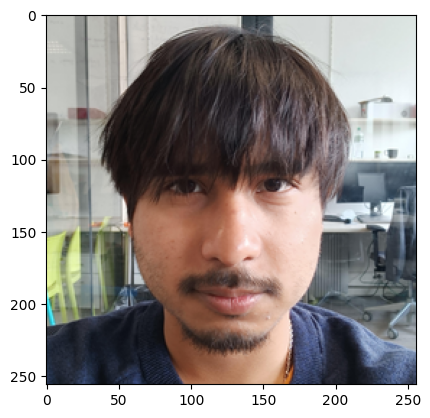

In [49]:
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()
plt.imshow(batch[1].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [50]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [51]:
cond.shape, xT.shape

(torch.Size([2, 512]), torch.Size([2, 3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.903333..5.9356494].


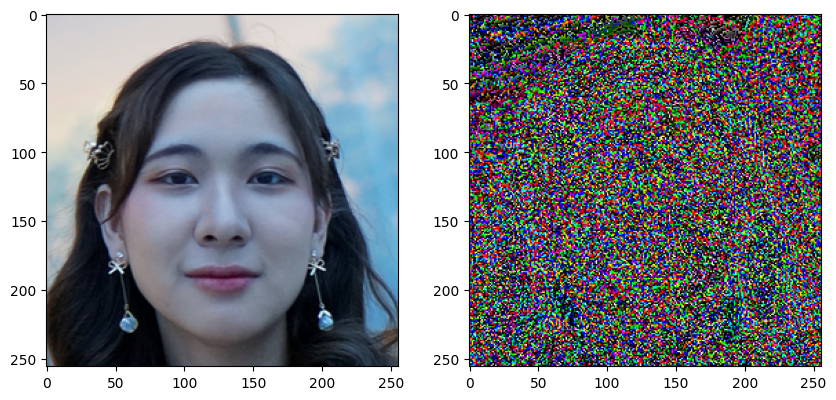

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

## Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [53]:
cond[0][None].shape

torch.Size([1, 512])

In [54]:
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
print(intp_x.shape)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=20)

torch.Size([10, 196608])


In [55]:
theta

tensor(1.5700, device='cuda:1')

In [56]:
intp.shape, intp_x.shape

(torch.Size([10, 512]), torch.Size([10, 3, 256, 256]))

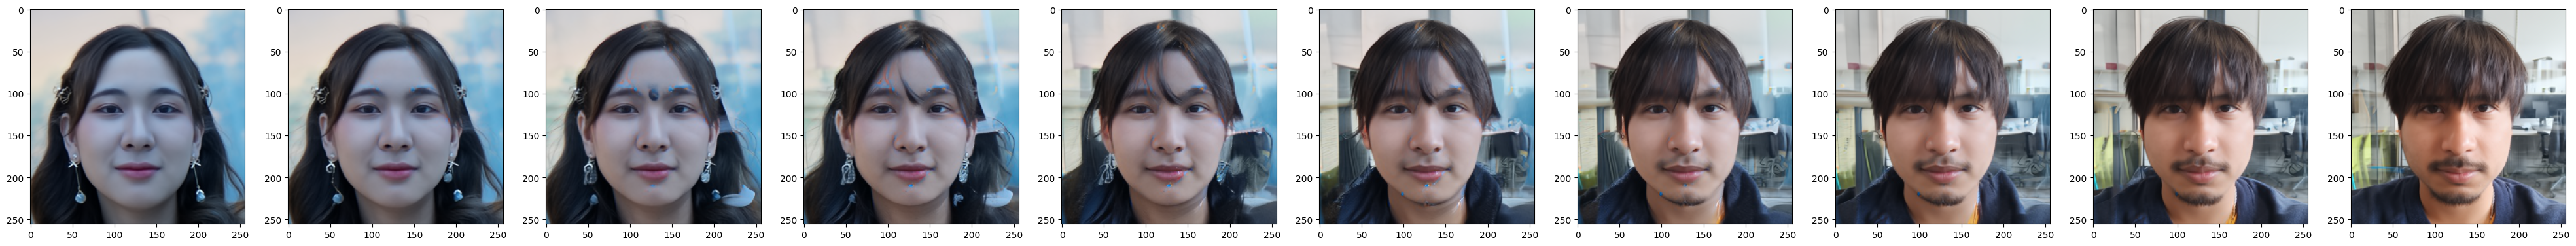

In [57]:
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())

plt.savefig('imgs_interpolated/sandy2saranga_256.png')